In [ ]:
## for plotting SSH / ocean color underway 

In [165]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from os import listdir
import glob
import os
import pandas as pd
import imageio
import scipy

from matplotlib.animation import FuncAnimation, PillowWriter  
import matplotlib.colors as mcolors

## scripts to download Copernicus SSH files 

In [5]:
# Script to create configuration files .dodsrc and _netrc
# for an easy access to the OPeNDAP API

import os
import getpass

# Enter Copernicus credentials
USERNAME = getpass.getpass('Enter your Copernicus username: ')
PASSWORD = getpass.getpass('Enter your Copernicus password: ')

# Create .dodsrc
f = open(".dodsrc", "w", encoding="utf-8")
f.write("HTTP.NETRC="+os.path.expanduser('~')+"\\_netrc"+'\n')
f.write("HTTP.COOKIEJAR="+os.path.expanduser('~')+"\\.cookies")
f.close()

# Create _netrc
f = open("_netrc", "w", encoding="utf-8")
f.writelines(["machine my.cmems-du.eu", '\n', "login "+USERNAME, '\n', "password "+PASSWORD, '\n', '\n'])
f.writelines(["machine nrt.cmems-du.eu", '\n', "login "+USERNAME, '\n', "password "+PASSWORD])
f.close()


import pandas as pd
import datetime as dt
import numpy as np 
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import xarray as xr

# import nctoolkit as nc 

'''
# satellite filepath

fn = 'https://nrt.cmems-du.eu/thredds/dodsC/dataset-duacs-nrt-global-merged-allsat-phy-l4.nc'

# see metadata at:
# https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046/services

sat = Dataset(fn,format='NETCDF')
'''


# Dataset ID
DATASET_ID = 'dataset-duacs-nrt-global-merged-allsat-phy-l4.html'
#DATASET_ID = 'global-analysis-forecast-phy-001-024.html'

# Subsetting parameters

today = dt.date.today()
mostrecent = dt.date.today() - dt.timedelta(days=2) #necessary bc of delayed data availability
mostrecent= str(mostrecent.strftime("%Y-%m-%d"))

DEPTH = 0
LATITUDE = slice(-15,10)
LONGITUDE = slice(-30,-40)

# Read product via OPeNDAP
DS = (
    xr.open_dataset(f"https://nrt.cmems-du.eu/thredds/dodsC/{DATASET_ID}")
    .sel(time=TIME, latitude=LATITUDE, longitude=LONGITUDE)
    .isel(depth=DEPTH)
)



SSH = DS.to_netcdf

Enter your Copernicus username:  ········
Enter your Copernicus password:  ········


Cookie file cannot be read and written: /home/vboatwright\.cookies


OSError: [Errno -37] NetCDF: Write to read only: 'https://nrt.cmems-du.eu/thredds/dodsC/dataset-duacs-nrt-global-merged-allsat-phy-l4.html'

## plotting SSH 

In [4]:
#load datasets of SSH 

home = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia'
# eventually, home should be file share for ship 

datasets=glob.glob(home+'dataset*')
print(datasets)

#os.system('cd X:/M188/SSH/Data/')
#os.system('ls')
#print(datasets[0]) #latest dataset

[]


## downloading NASA Ocean color files 

In [7]:

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy
import earthaccess
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import os
import netCDF4 

## login and find desired data 

In [12]:
# authenticate into NASA earthdata 

auth = earthaccess.login(persist=True)


In [28]:

# here you can find a different dataset for daily results: https://search.earthdata.nasa.gov/search

# want L2 data, daily 

results = earthaccess.search_datasets(
    keyword="L2 ocean color modis aqua chlorophyll",
    instrument="MODIS",
)

set((i.summary()["short-name"] for i in results))


{'MODISA_L2_OC', 'MODISA_L2_OC_NRT', 'MODIST_L2_OC'}

In [105]:

# here you can find a different dataset for daily results: https://search.earthdata.nasa.gov/search

# want L3 data, daily 

results = earthaccess.search_datasets(
    keyword="L3m ocean color modis aqua chlorophyll",
    instrument="MODIS",
)

set((i.summary()["short-name"] for i in results))


{'MODISA_L3m_CHL', 'MODISA_L3m_CHL_NRT', 'MODIST_L3m_CHL'}

## redownloading up until day 

In [136]:
xmin,xmax = -122, -118
ymin, ymax = 32, 36

bbox = (degxmin+1, ymin-1, degxmax-1, ymax+1)
today = datetime.now().strftime("%Y-%m-%d")
tspan = ("2025-02-01", today)

results = earthaccess.search_data(
    short_name="MODISA_L3m_CHL_NRT",
    temporal=tspan,
)


In [124]:
results[0]

Collection: {'Version': 'R2022.0', 'ShortName': 'MODISA_L3m_CHL_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'NorthBoundingCoordinate': 90, 'SouthBoundingCoordinate': -90, 'WestBoundingCoordinate': -180, 'EastBoundingCoordinate': 180}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-02-01T23:59:59Z', 'BeginningDateTime': '2025-01-25T00:00:00Z'}}
Size(MB): 42.093082427978516
Data: ['https://oceandata.sci.gsfc.nasa.gov/cmr/getfile/AQUA_MODIS.20250125_20250201.L3m.8D.CHL.chlor_a.4km.NRT.nc']

In [137]:
# only download new files! 

local_dir = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/data/L3m_CHL_NRT_StLucia/'
existing_files = set(os.listdir(local_dir))

urls_to_download = []
for entry in results:
    entry_dict = dict(entry)  # converting earthacess object
    if "umm" in entry_dict and "RelatedUrls" in entry_dict["umm"]:
        for url_info in entry_dict["umm"]["RelatedUrls"]:
            if url_info.get("Type") == "GET DATA" and url_info.get("Subtype") == "DIRECT DOWNLOAD":
                url = url_info["URL"]
                filename = os.path.basename(url)  # Extract filename
                if filename not in existing_files:  # Only add if not already downloaded
                    urls_to_download.append(url)                

# only download new files
if urls_to_download:
    paths = earthaccess.download(urls_to_download, local_dir)
else:
    print("All files are already downloaded. No new files to download.")
    


All files are already downloaded. No new files to download.


In [29]:

xmin = -122
xmax = -118

degxmin = -180-xmin
print(degxmin)
degxmax = -180-xmax
print(degxmax)

xmin = -122
xmax = -118

degxmin = -180-xmin
degxmax = -180-xmax

ymin = 32
ymax = 36

# bbox = [lat1, lon1, lat2, lon2] 
# bbox = [lon1, lat1, lon2, lat2] 

# e.g.: 
#bbox = (-57, 32, -63, 36)
bbox = (degxmin+1, ymin-1, degxmax-1, ymax+1)
tspan = ("2025-02-01", "2025-02-21")

results = earthaccess.search_data(
    short_name="MODISA_L2_OC_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

-58
-62


In [30]:
results[0]

Collection: {'Version': 'R2022.0', 'ShortName': 'MODISA_L2_OC_NRT'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 43.93103, 'Longitude': -157.57887}, {'Latitude': 39.96311, 'Longitude': 175.20941}, {'Latitude': 22.87639, 'Longitude': -177.4765}, {'Latitude': 26.11541, 'Longitude': -155.25967}, {'Latitude': 43.93103, 'Longitude': -157.57887}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-02-01T01:24:59Z', 'BeginningDateTime': '2025-02-01T01:20:01Z'}}
Size(MB): 35.38784694671631
Data: ['https://oceandata.sci.gsfc.nasa.gov/cmr/getfile/AQUA_MODIS.20250201T012001.L2.OC.NRT.nc']

In [31]:
'''
tspan = ("2025-02-01", "2025-02-21")
product_name = 'AQUA_MODIS.20250220T220501.L2.OC.NRT.nc'

results = earthaccess.search_data(
    long_name=product_name,
    temporal=tspan,
)
results[0]
'''

'tspan = ("2025-02-01", "2025-02-21")\nproduct_name = \'AQUA_MODIS.20250220T220501.L2.OC.NRT.nc\'\n\nresults = earthaccess.search_data(\n    long_name=product_name,\n    temporal=tspan,\n)\nresults[0]\n'

In [ ]:
# download data - make sure to save in data file! 

paths = earthaccess.download(results, "/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/data/L2_CHL_NRT_StLucia_4km")


In [156]:
# sort the files by date 

#os.listdir('/home/vboatwright/santalucia/L3_2024trial/')
path = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/data/L3m_CHL_NRT_StLucia/'
files = os.listdir(path)

# dates are sorted for these at characters 12:20 
sorted_files = sorted(files, key=lambda x: x[12:20])
print(sorted_files)

# readable files: 
readable_files = []

for nc_file in sorted_files:
    try:
        with netCDF4.Dataset(nc_file, "r") as ds:
            readable_files.append(nc_file)
            # print(f"Successfully opened {nc_file}")
            # Print available variables: print(ds.variables.keys())
    except OSError as e:
        if "HDF error" in str(e):
            print(f"Skipping {nc_file} due to HDF error.")
        else:
            print(f"Skipping {nc_file} due to unexpected error: {e}")
    except Exception as e:
        print(f"Skipping {nc_file} due to general error: {e}")

print(f'Readable files = {len(readable_files)}')

['AQUA_MODIS.20250125_20250201.L3m.8D.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250125_20250201.L3m.8D.CHL.chlor_a.9km.NRT.nc', 'AQUA_MODIS.20250201.L3m.DAY.CHL.chlor_a.9km.NRT.nc', 'AQUA_MODIS.20250201.L3m.DAY.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250202.L3m.DAY.CHL.chlor_a.9km.NRT.nc', 'AQUA_MODIS.20250202.L3m.DAY.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250202_20250209.L3m.8D.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250202_20250209.L3m.8D.CHL.chlor_a.9km.NRT.nc', 'AQUA_MODIS.20250203.L3m.DAY.CHL.chlor_a.9km.NRT.nc', 'AQUA_MODIS.20250203.L3m.DAY.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250204.L3m.DAY.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250204.L3m.DAY.CHL.chlor_a.9km.NRT.nc', 'AQUA_MODIS.20250205.L3m.DAY.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250205.L3m.DAY.CHL.chlor_a.9km.NRT.nc', 'AQUA_MODIS.20250206.L3m.DAY.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250206.L3m.DAY.CHL.chlor_a.9km.NRT.nc', 'AQUA_MODIS.20250207.L3m.DAY.CHL.chlor_a.4km.NRT.nc', 'AQUA_MODIS.20250207.L3m.DAY.CHL.chlor_a.9km.NRT.

In [ ]:
# sort the files by date 

#os.listdir('/home/vboatwright/santalucia/L3_2024trial/')
path = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/data/L3m_CHL_NRT_StLucia/'
files = os.listdir(path)

# dates are sorted for these at characters 12:20 
sorted_files = sorted(files, key=lambda x: x[12:20])
print(sorted_files)

# readable files: 
readable_files = []

for nc_file in sorted_files:
    try:
        with netCDF4.Dataset(nc_file, "r") as ds:
            readable_files.append(nc_file)
            # print(f"Successfully opened {nc_file}")
            # Print available variables: print(ds.variables.keys())
    except OSError as e:
        if "HDF error" in str(e):
            print(f"Skipping {nc_file} due to HDF error.")
        else:
            print(f"Skipping {nc_file} due to unexpected error: {e}")
    except Exception as e:
        print(f"Skipping {nc_file} due to general error: {e}")

print(f'Readable files = {len(readable_files)}')

matched_files = [f for f in files if fnmatch.fnmatch(f, 'MET_*.mat')]

## access and plot ocean color 

In [57]:
# access 
dataset = xr.open_dataset(readable_files[0])
S = netCDF4.Dataset(path+readable_files[0]) 
S

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    product_name: AQUA_MODIS.20250125_20250201.L3m.8D.CHL.chlor_a.9km.NRT.nc
    instrument: MODIS
    title: MODISA Level-3 Standard Mapped Image
    project: Ocean Biology Processing Group (NASA/GSFC/OBPG)
    platform: Aqua
    source: satellite observations from MODIS-Aqua
    temporal_range: 8-day
    processing_version: R2022.0.2
    date_created: 2025-02-02T13:24:48.000Z
    history: l3mapgen par=AQUA_MODIS.20250125_20250201.L3m.8D.CHL.chlor_a.9km.NRT.nc.param 
    l2_flag_names: ATMFAIL,LAND,HILT,HISATZEN,STRAYLIGHT,CLDICE,COCCOLITH,LOWLW,CHLWARN,CHLFAIL,NAVWARN,MAXAERITER,ATMWARN,HISOLZEN,NAVFAIL,FILTER,HIGLINT
    time_coverage_start: 2025-01-25T00:10:00.000Z
    time_coverage_end: 2025-02-02T02:19:58.000Z
    start_orbit_number: 120946
    end_orbit_number: 121064
    map_projection: Equidistant Cylindrical
    latitude_units: degrees_north
    longitude_units: degrees_east
    northernmost_latitude

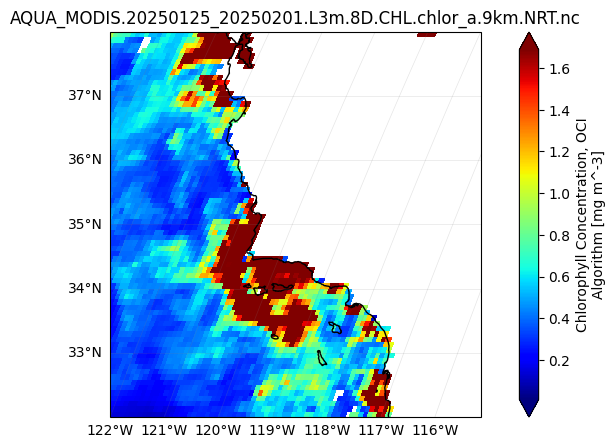

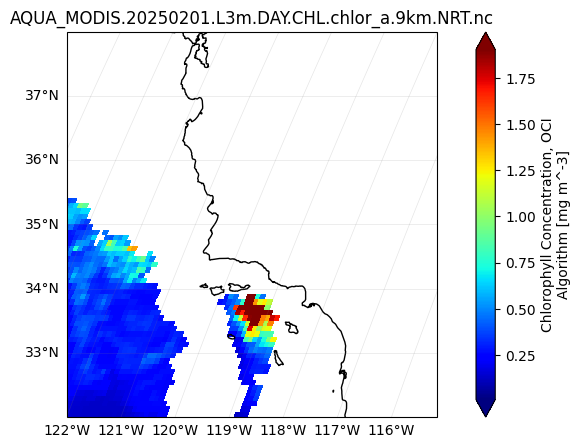

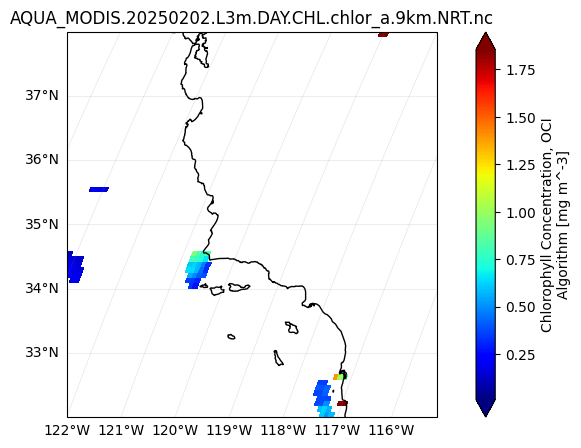

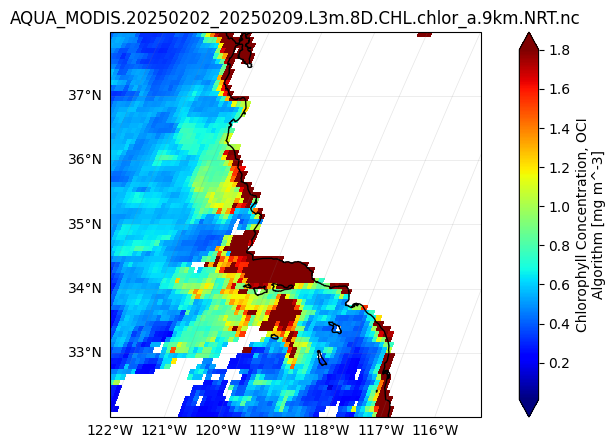

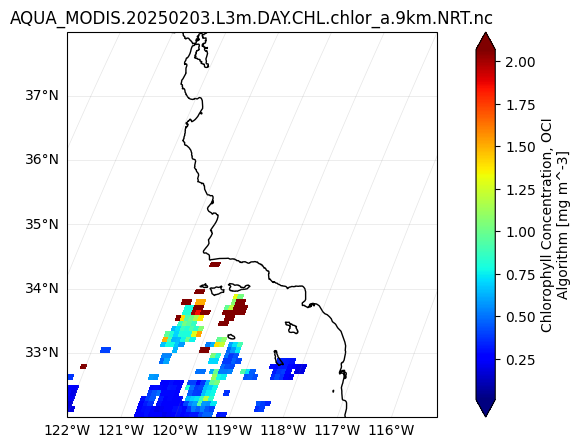

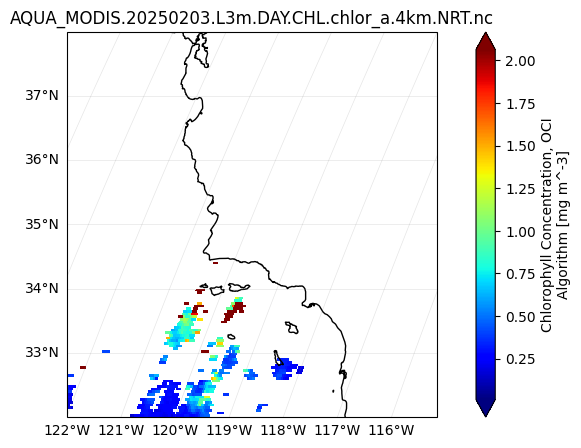

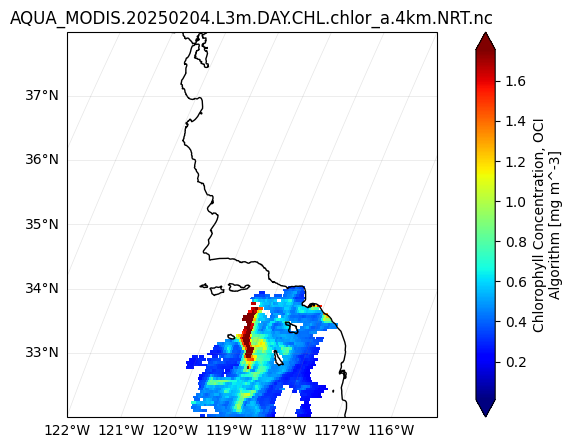

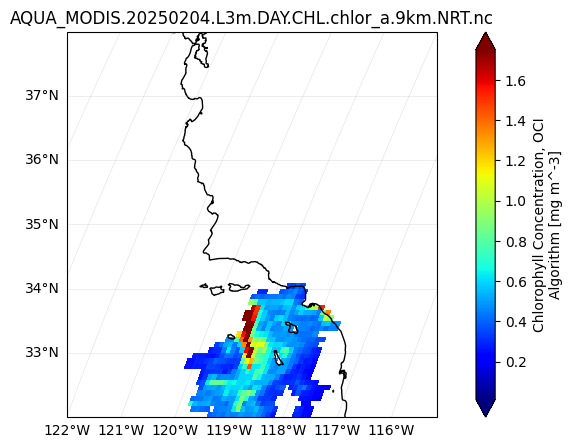

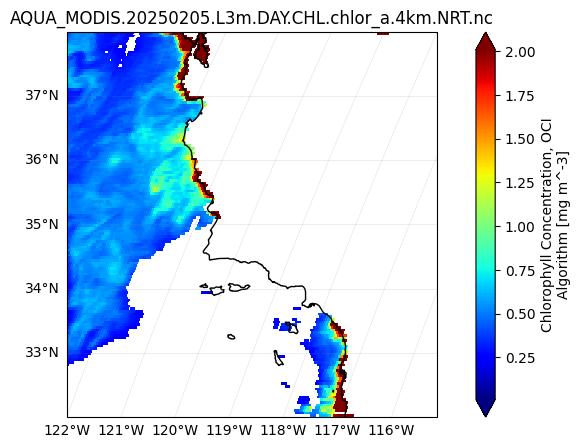

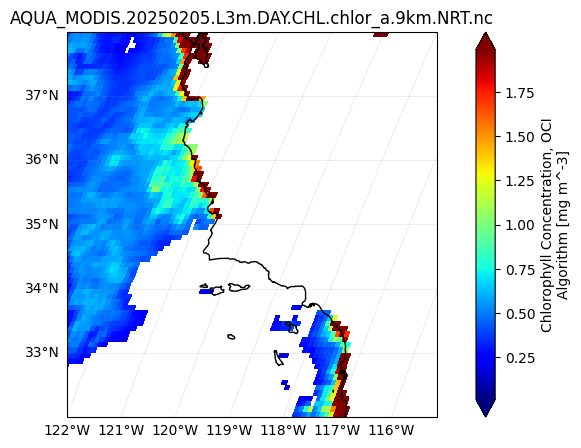

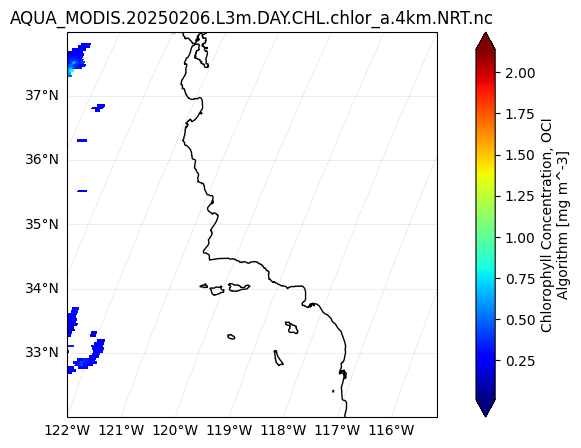

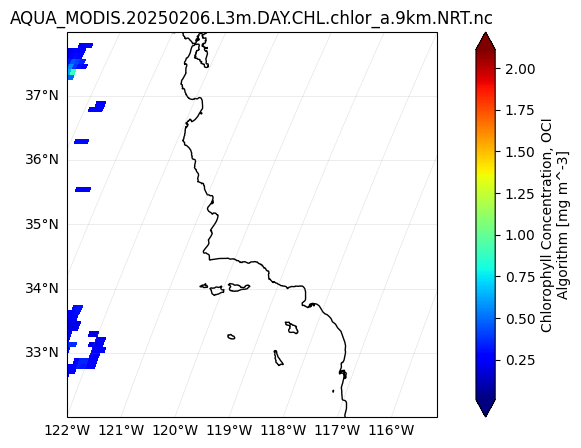

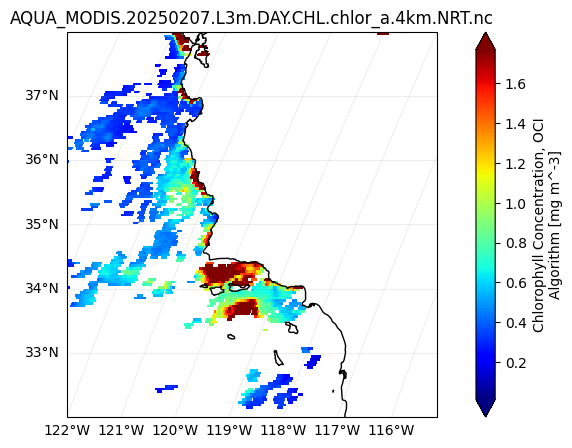

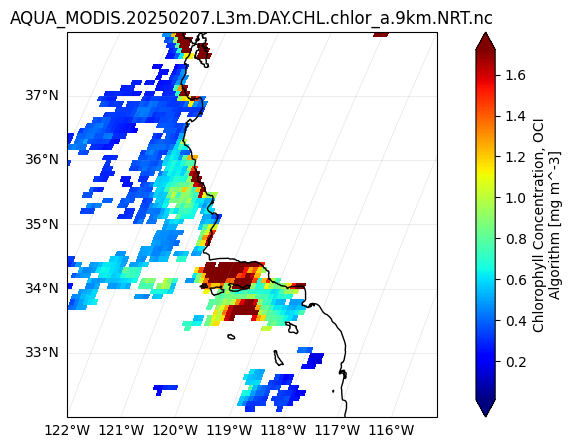

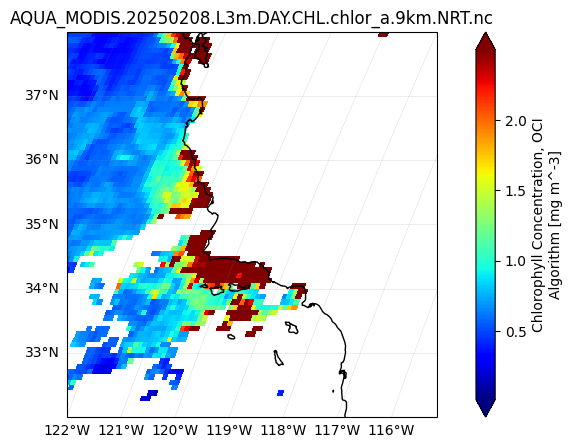

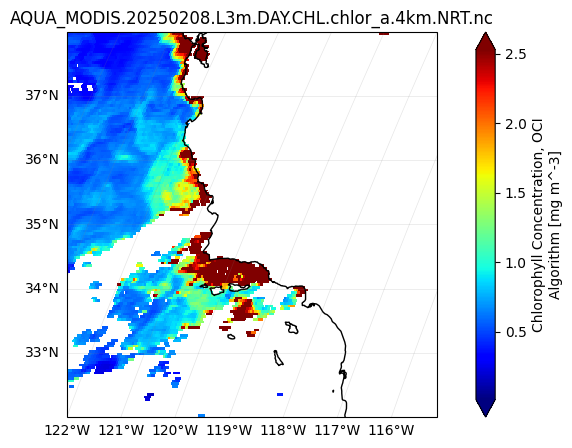

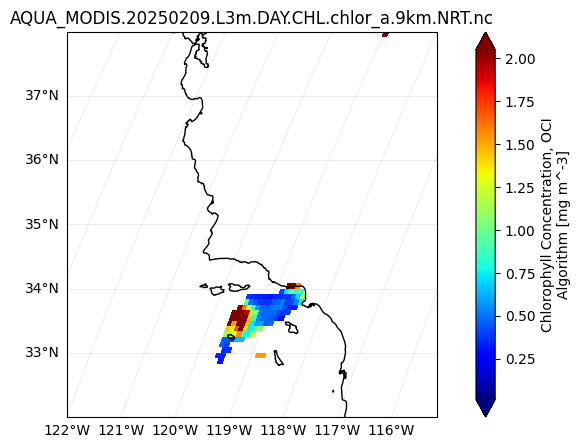

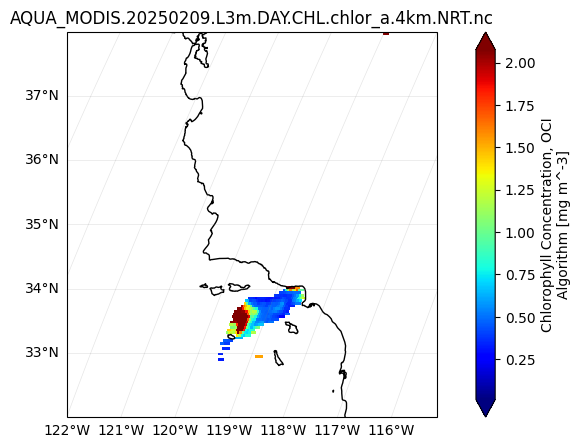

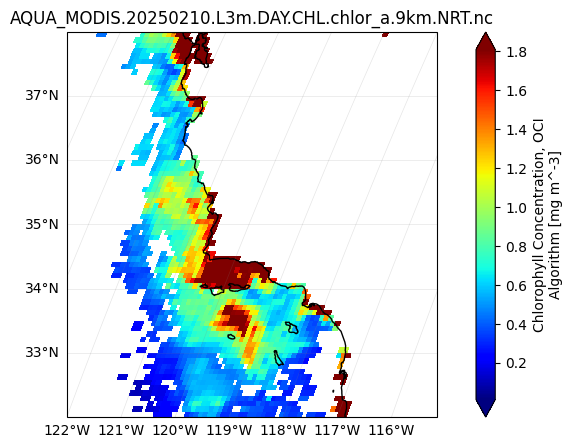

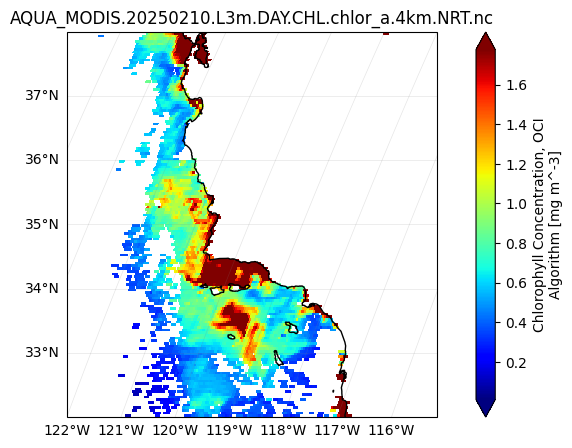

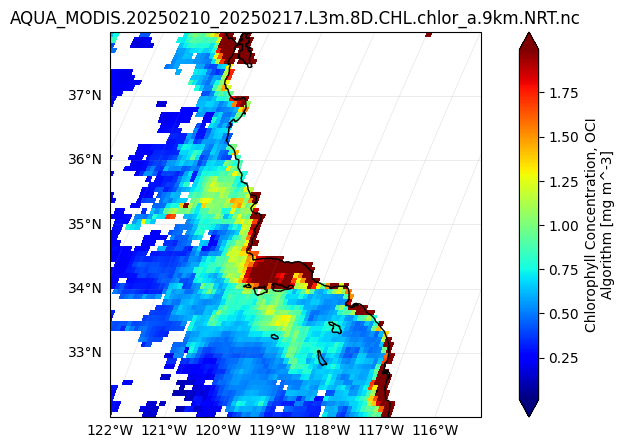

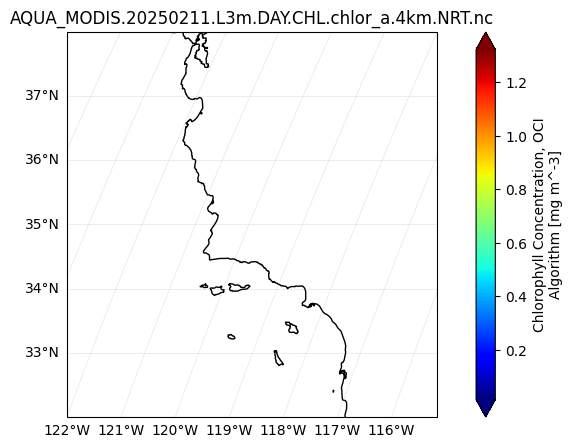

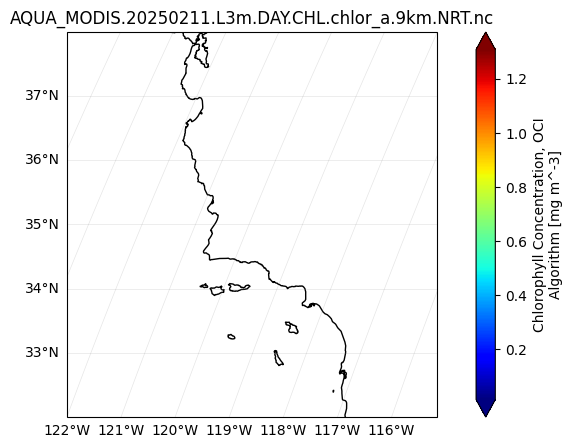

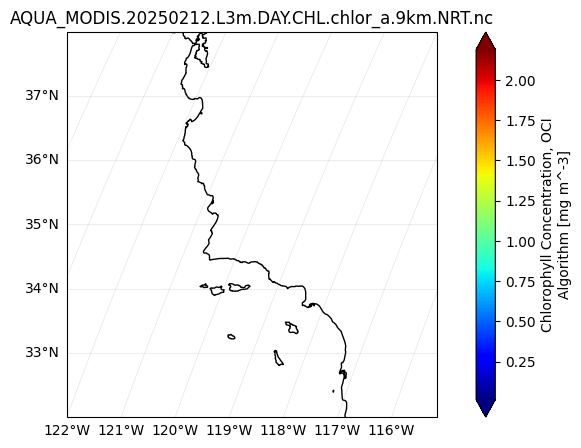

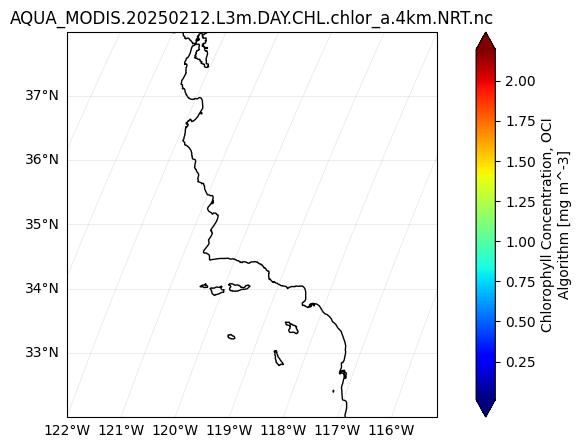

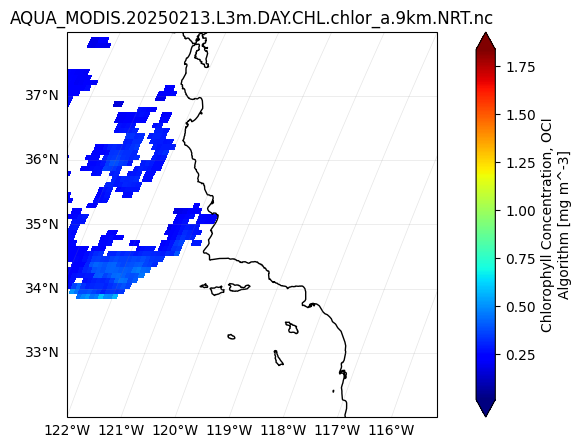

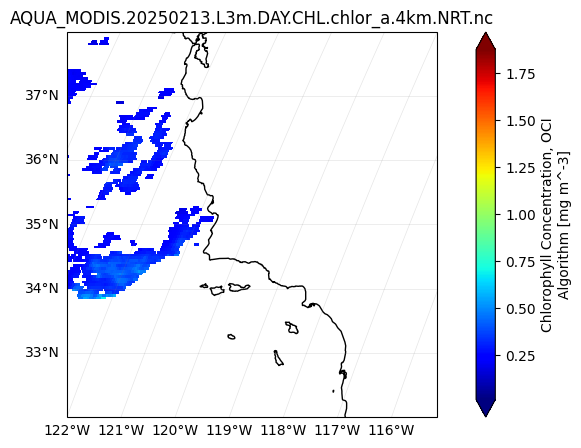

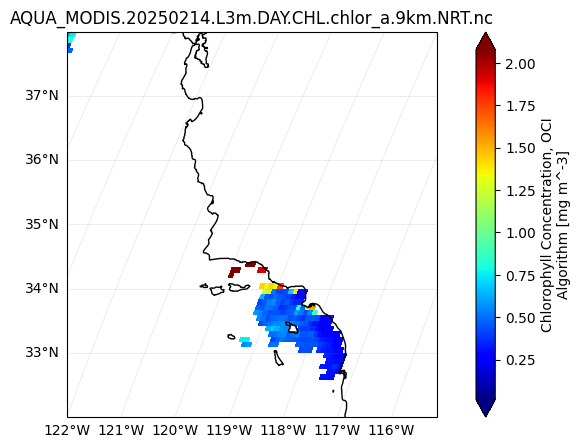

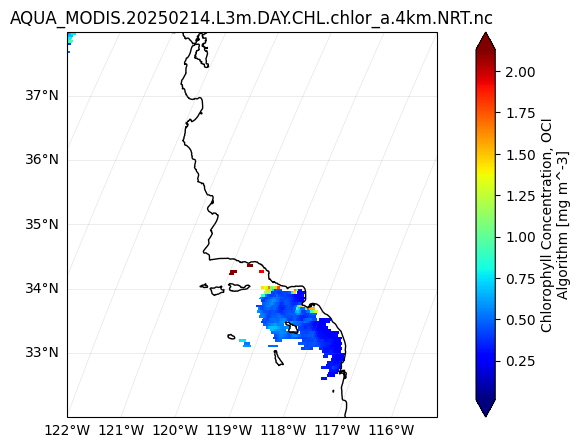

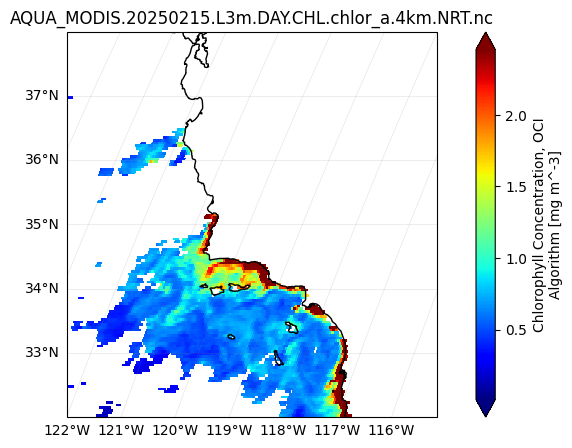

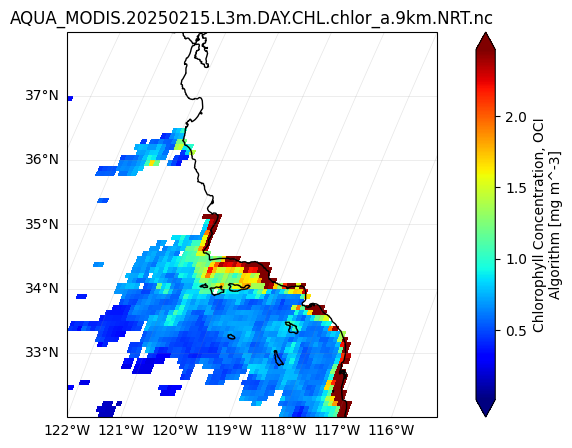

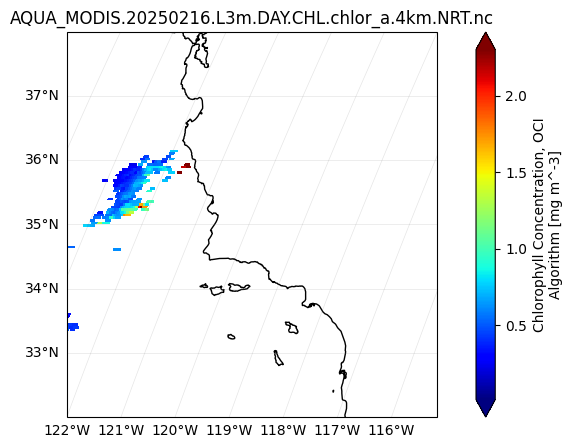

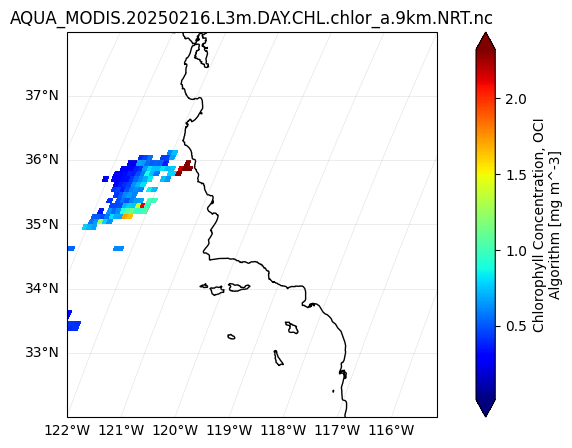

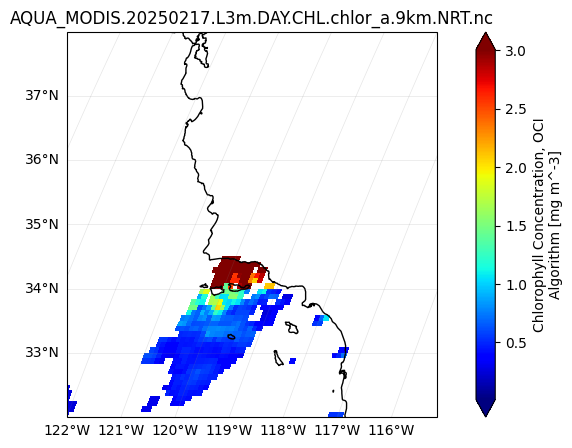

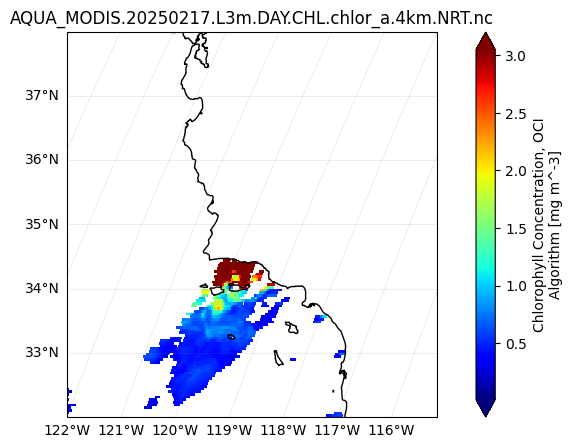

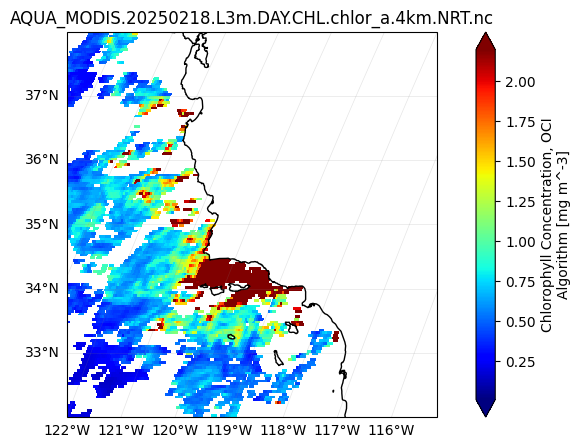

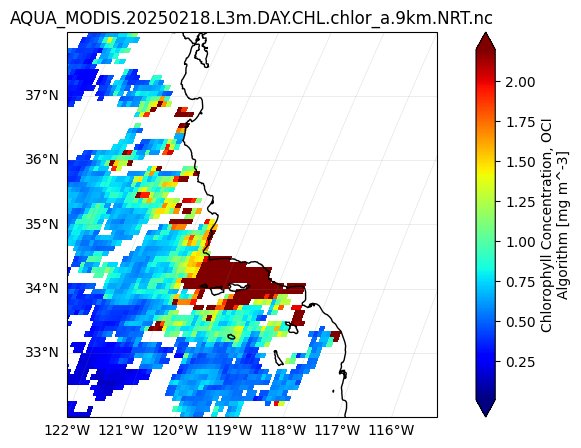

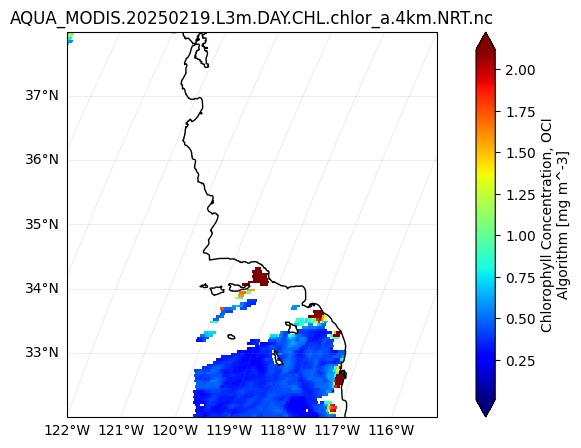

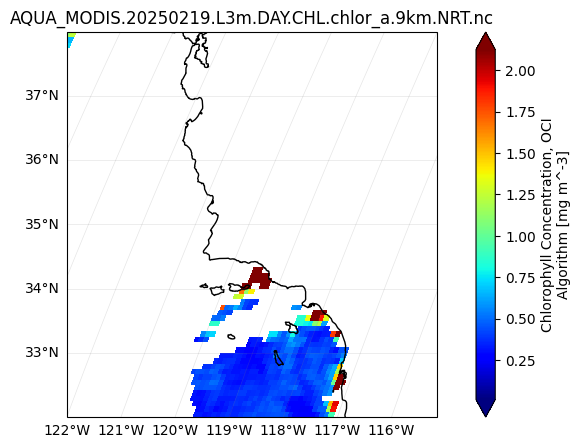

In [60]:
# plotting 

path = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/data/L3m_CHL_NRT_StLucia/'
files = os.listdir(path)

# area: bbox = (-76.75, 36.97, -75.74, 39.01)

xmin = -124
xmax = -114

ymin = 32
ymax = 36

sdlonlat = [-117.24556,32.928333]
chl_extent = [0,3]

# now perform for each 8day segment that i have 

for ff in readable_files: 
    dataset = xr.open_dataset(path+ff) 
    try: 
        chl = dataset["chlor_a"]
           
        crs_proj = cartopy.crs.Robinson()
        crs_data = cartopy.crs.PlateCarree()
        
        
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(projection=crs_proj)
        chl.plot(x="lon", y="lat", cmap="jet", ax=ax, vmin=chl_extent[0], vmax=chl_extent[1],robust=True, transform=crs_data)
        ax.set_extent((xmin,xmax,ymin,ymax))
        ax.coastlines()
        gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.2, linestyle='-')  
        gl.top_labels = False; gl.right_labels = False 
        gl.xlocator = mticker.MultipleLocator(1) 
        gl.ylocator = mticker.MultipleLocator(1) 
        ax.scatter(sdlonlat[0],sdlonlat[1],color='red',marker='*',label='SD')
        ax.set_title(dataset.attrs["product_name"])
        plt.show()
        
    except: 
        print('no chl')
        


In [183]:
## animate 

import matplotlib.animation as animation
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

path = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/data/L3m_CHL_NRT_StLucia/'
files = os.listdir(path)

readable_files = []
for nc_file in sorted_files:
    try:
        with netCDF4.Dataset(nc_file, "r") as ds:
            readable_files.append(nc_file)
    except OSError as e:
        if "HDF error" in str(e):
            print(f"Skipping {nc_file} due to HDF error.")
        else:
            print(f"Skipping {nc_file} due to unexpected error: {e}")
    except Exception as e:
        print(f"Skipping {nc_file} due to general error: {e}")

sorted_files = sorted(readable_files, key=lambda x: x[11:19])


# select for only the desired timestep satellite grabs 

daily9km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*DAY*9km*.nc')]
daily4km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*DAY*4km*.nc')]
comp8d4km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*8D*4km*.nc')]


# now perform for each day satellite file that i have 

# set bounds
xmin, xmax = -124, -117
ymin, ymax = 32, 36
sdlonlat = [-117.24556, 32.928333]
chl_extent = [0, 3]

# loop through all valid files
chl_data = []
titles = []
lon, lat = None, None  

res = '4km' # 9 or 4 km 
for ff in daily4km_files:
    dataset = xr.open_dataset(path+ff)
    chl = dataset["chlor_a"]
    if lon is None or lat is None:
        lon, lat = np.meshgrid(dataset["lon"], dataset["lat"])
    chl_data.append(chl.values)
    given_date = datetime.strptime(dataset.attrs.get("product_name", ff)[11:19], "%Y%m%d")
    titles.append(f'Daily {res} on {given_date.strftime("%Y-%m-%d")}')  

# check if we loaded data
if not chl_data:
    raise ValueError("No valid chlorophyll data found.")


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
crs_data = ccrs.PlateCarree()

# create empty plot for animation 
mesh = ax.pcolormesh(lon, lat, chl_data[0], cmap="jet", vmin=chl_extent[0], vmax=chl_extent[1], transform=crs_data)
# log scale plot: 
# change mins: 
#chl_extent = [1e-2, 3]
#mesh = ax.pcolormesh(lon,lat,chl_data[0],cmap='jet',transform=crs_data,norm=mcolors.LogNorm(vmin=chl_extent[0],vmax=chl_extent[1]) )
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label(r'Chlorophyll Concentration [mg/$m^3$]')

ax.set_extent((xmin, xmax, ymin, ymax))
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color="gray", alpha=0.2, linestyle="-")
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.MultipleLocator(1)
gl.ylocator = mticker.MultipleLocator(1)

# reference SD 
ax.scatter(sdlonlat[0], sdlonlat[1], color="red", marker="*", label="SD")
title = ax.set_title(titles[0])

# update animation via function
def update(frame):
    mesh.set_array(chl_data[frame].ravel())  # update pcolormesh data
    title.set_text(titles[frame])  # update title
    return mesh, title

ani = animation.FuncAnimation(fig, update, frames=len(chl_data), interval=500, blit=False)
plt.show()

# save as GIF
save_loc = '/home/vboatwright/OneDrive/Documents/SIO/projects/santalucia/at_sea/'
ani.save(save_loc+'santalucia_daily_aquamodis_'+res+'.gif', writer="pillow", fps=1)

# save as MP4 - not currently loaded correctly
# ani.save("chlorophyll_animation.mp4", writer="ffmpeg", fps=5)




<IPython.core.display.Javascript object>

In [199]:
comp8d9km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*8D*.nc')]

comp8d9km_files

['AQUA_MODIS.20250125_20250201.L3m.8D.CHL.chlor_a.9km.NRT.nc',
 'AQUA_MODIS.20250202_20250209.L3m.8D.CHL.chlor_a.9km.NRT.nc',
 'AQUA_MODIS.20250210_20250217.L3m.8D.CHL.chlor_a.9km.NRT.nc']

In [193]:
comp8d9km_files = [f for f in sorted_files if fnmatch.fnmatch(f, '*8D*9km*.nc')]

# loop through each 8day composite 

# set bounds
xmin, xmax = -124, -117
ymin, ymax = 32, 36
sdlonlat = [-117.24556, 32.928333]
chl_extent = [0, 3]


for ff in comp8d9km_files: 
    dataset = xr.open_dataset(path+ff) 
    chl = dataset["chlor_a"]
    lon, lat = np.meshgrid(dataset["lon"], dataset["lat"])
       
    crs_proj = cartopy.crs.Robinson()
    crs_data = cartopy.crs.PlateCarree()
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(projection=crs_proj)
    mesh = ax.pcolormesh(lon, lat, chl, cmap="jet", vmin=chl_extent[0], vmax=chl_extent[1], transform=crs_data)
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label(r'Chlorophyll Concentration [mg/$m^3$]')
    ax.set_extent((xmin,xmax,ymin,ymax))
    ax.coastlines()
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,linewidth=.5, color='gray', alpha=0.2, linestyle='-')  
    gl.top_labels = False; gl.right_labels = False 
    gl.xlocator = mticker.MultipleLocator(1) 
    gl.ylocator = mticker.MultipleLocator(1) 
    d0 = datetime.strptime(dataset.attrs.get("product_name", ff)[11:19], "%Y%m%d")
    d1 = datetime.strptime(dataset.attrs.get("product_name", ff)[20:28], "%Y%m%d")
    ax.set_title(f'8 Day Composite @ 9km for {d0.strftime("%m-%d")} : {d0.strftime("%m-%d")}')
    plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [192]:
chl.shape

(2160, 4320)

In [ ]:
# nice! next we will access the ship data in order to get ship location as we go 

### access met file data from science share folder 


In [ ]:
'smb://sr-sci-filesvr.ucsd.edu/scienceparty_share/SR2503_scienceparty_share/MetData/SR2503_MET.mat'

In [94]:
path = '/home/vboatwright/OneDrive/Documents/SIO/projects/estuarystorms/data/LPL_watergauge/'
filename = 'riverFlowUSGS_2014_2024.mat'
fn = path+filename

fn = 'smb://sr-sci-filesvr.ucsd.edu/scienceparty_share/SR2503_scienceparty_share/MetData/SR2503_MET.mat'
fn = '/home/vboatwright/mnt/scienceparty_share/SR2503_scienceparty_share/MetData/MET_250220.mat'

dat = scipy.io.loadmat(fn)
dat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Feb 21 22:40:14 2025',
 '__version__': '1.0',
 '__globals__': [],
 'MET': array([[(array([[739668.        ],
                [739668.00001157],
                [739668.00002315],
                ...,
                [739668.99996528],
                [739668.99997685],
                [739668.99998843]]), array([[16.81],
                [16.8 ],
                [16.8 ],
                ...,
                [14.44],
                [14.44],
                [14.44]]), array([[1015.36],
                [1015.36],
                [1015.36],
                ...,
                [1011.31],
                [1011.31],
                [1011.31]]), array([[1016.94],
                [1016.94],
                [1016.94],
                ...,
                [1012.89],
                [1012.89],
                [1012.9 ]]), array([[73.94],
                [73.95],
                [73.96],
                ...,
                [9

In [68]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy.io import loadmat

def load_mat_file(file_path):
    """
    Load any .mat file and extract its contents into a dictionary of NumPy arrays or a DataFrame.
    """
    def convert_matlab_datenum(matlab_datenums):
        """ Convert MATLAB datenum to Python datetime. """
        matlab_epoch = datetime(1, 1, 1)  # MATLAB starts at year 1
        days_offset = 366  # MATLAB incorrectly includes year 0 as a leap year
        return np.array([matlab_epoch + timedelta(days=t - days_offset) for t in matlab_datenums])

    def extract_variables(mat_data):
        """ Recursively extract all variables from a loaded .mat file. """
        extracted = {}

        for key, value in mat_data.items():
            if key.startswith("__"):  # Ignore metadata keys
                continue

            # Handle structured arrays (dtype=object)
            if isinstance(value, np.ndarray) and value.dtype.names:
                struct_data = {field: value[field].squeeze() for field in value.dtype.names}
                extracted[key] = struct_data

            # Handle MATLAB cell arrays (lists of arrays)
            elif isinstance(value, np.ndarray) and value.dtype == object:
                extracted[key] = [v.squeeze() if isinstance(v, np.ndarray) else v for v in value]

            # Handle standard arrays
            else:
                extracted[key] = value.squeeze()

        return extracted

    # Load the .mat file
    mat_data = loadmat(file_path)

    # Extract all variables
    extracted_data = extract_variables(mat_data)

    # Convert any MATLAB datenums to Python datetime
    for key, value in extracted_data.items():
        if isinstance(value, np.ndarray) and np.issubdtype(value.dtype, np.number) and np.min(value) > 700000:
            try:
                extracted_data[key] = convert_matlab_datenum(value)
            except:
                pass  # Skip if conversion fails

    # Attempt to create a pandas DataFrame
    try:
        df = pd.DataFrame(extracted_data)
        return df
    except:
        return extracted_data


In [69]:

# Example usage
data = load_mat_file(fn)

# check dataframe 
if isinstance(data, pd.DataFrame):
    print(data.head())
else:
    for key, value in data.items():
        print(f"{key}: {type(value)}, shape={value.shape if isinstance(value, np.ndarray) else 'N/A'}")


                                                    MET
time  [[739668.        ]\n [739668.00001157]\n [7396...
AT    [[16.81]\n [16.8 ]\n [16.8 ]\n ...\n [14.44]\n...
BP    [[1015.36]\n [1015.36]\n [1015.36]\n ...\n [10...
BS    [[1016.94]\n [1016.94]\n [1016.94]\n ...\n [10...
RH    [[73.94]\n [73.95]\n [73.96]\n ...\n [91.66]\n...


## try instead getting directly from the .MET files 

In [ ]:
def getting_meta(start):
    if start=='y':
        shipinfo=('')# enter the ship metadata path here
        shipinfo=('/home/vboatwright/mnt/cruise/SR2503/metacq/data/')
        # shipinfo='/Users/allenlab/Documents/ifcbdb/ifcbdb/ifcb_data/P2402_underway/P2402_Met/' # address of the ship info, connected to the server and shared folder
        dataname=input('the experiment name calcofi2404_underway/discrete:')
        
        metadatapath=f'/Users/allenlab/Documents/ifcbdb/ifcbdb/ifcb_data/calcofi2404_{dataname}/metadata.csv'
        if not os.path.exists(metadatapath):
            if dataname=='underway':
                metadata=pd.DataFrame({'filename':[],'Latitude':[],'Longitude':[]})
            else:
                metadata=pd.DataFrame({'filename':[],'Latitude':[],'Longitude':[],'Depth':[],'Cruise':[],'Sampletype':[],'Niskin':[]})
        else:
            metadata=pd.read_csv(metadatapath)

        if dataname=='underway':
            for file in ifcbfiles:
                filename=file[:-4]
                if metadata[metadata['filename'].isin([filename])].empty:
                    time=int(file[10:16]) # convert the string to interger
                    day=file[3:9]
                    shipdata=np.loadtxt(shipinfo+day+'.MET',usecols=(0,24,25))
                    if shipdata[1,2]>0 or shipdata[1,2]<-100:
                        shipdata=np.loadtxt(shipinfo+day+'.MET',usecols=(0,24,25))
                    metatime=min(shipdata[:,0], key=lambda x:abs(x-time))
                    if metatime!=lasttime:
                        lasttime=metatime
                        subset=shipdata[shipdata[:,0]==metatime,:]
                        La,Lon=subset[0,1:3]
                        df2 = pd.DataFrame({'filename': filename, 'Latitude': [La], 'Longitude':[Lon]})
                        metadata = pd.concat([metadata,df2], ignore_index = True) 
                        update+=1
                    else:
                        print('no latest metadata, please update the CalCOFI_MET file')
        else:
           metadata,updates=compile_meta(ifcbfiles,metadata,0)
           update+=updates
        metadata.to_csv(metadatapath, index=False)
        print('updates '+str(update)+' files, total '+str(len(ifcbfiles))+' files')
        print(f'Save to {metadatapath}')
        start=input('Do you want to do another dataset?[y/n]:')
        return getting_meta(start)
    else:
        print('End getting_metadata.py')


In [ ]:
if dataname=='underway':
            for file in ifcbfiles:
                filename=file[:-4]
                if metadata[metadata['filename'].isin([filename])].empty:
                    time=int(file[10:16]) # convert the string to interger
                    day=file[3:9]
                    shipdata=np.loadtxt(shipinfo+day+'.MET',usecols=(0,24,25))
                    if shipdata[1,2]>0 or shipdata[1,2]<-100:
                        shipdata=np.loadtxt(shipinfo+day+'.MET',usecols=(0,24,25))
                    metatime=min(shipdata[:,0], key=lambda x:abs(x-time))
                    if metatime!=lasttime:
                        lasttime=metatime
                        subset=shipdata[shipdata[:,0]==metatime,:]
                        La,Lon=subset[0,1:3]
                        df2 = pd.DataFrame({'filename': filename, 'Latitude': [La], 'Longitude':[Lon]})
                        metadata = pd.concat([metadata,df2], ignore_index = True) 
                        update+=1
                    else:
                        print('no latest metadata, please update the CalCOFI_MET file')
        else:
           metadata,updates=compile_meta(ifcbfiles,metadata,0)
           update+=updates
        metadata.to_csv(metadatapath, index=False)
        

In [214]:
shipinfo = '/home/vboatwright/mnt/cruise/SR2503/metacq/data/'

seadates = [dt.datetime(2025,2,19),dt.datetime(2025,2,20),dt.datetime(2025,2,21),dt.datetime(2025,2,22)]
longdays = [sd.strftime("%Y%m%d") for sd in seadates]
days = [sd.strftime("%y%m%d") for sd in seadates]
time = [int(dd) for dd in longdays]

NN = len(days) 
slons = []
slats = []

for ii in np.arange(0,NN): 
    shipdata = np.loadtxt(shipinfo+days[ii]+'.MET',usecols=(0,24,25))
    if shipdata[1,2]>0 or shipdata[1,2]<-100:
        shipdata=np.loadtxt(shipinfo+days[ii]+'.MET',usecols=(0,24,25))
    metatime=min(shipdata[:,0], key=lambda x:abs(x-time[ii]))
    subset=shipdata[shipdata[:,0]==metatime,:]
    lat,lon=subset[0,1:3]
    slons.append(lon)
    slats.append(lat)



[np.float64(-117.156746),
 np.float64(-118.215168),
 np.float64(-121.905273),
 np.float64(-122.454637)]

datetime.datetime(2025, 2, 10, 0, 0)

## accessing shipboard data 


In [92]:
import fnmatch

# cruise data path 
base = '/home/vboatwright/mnt/cruise/SR2503/'
scibase = '/home/vboatwright/mnt/scienceparty_share/SR2503_scienceparty_share/MetData'
met_data = 'metacq/data/'
path = scibase+met_data

files = os.listdir(scibase)

# filter for MET files 
met_files = [f for f in files if fnmatch.fnmatch(f, 'MET_*.mat')]

print(met_files)

['MET_250220.mat', 'MET_250221.mat', 'MET_250222.mat']


In [90]:
path

'/home/vboatwright/mnt/cruise/SR2503/metacq/data/'

In [91]:
files

['250219.COR',
 '250219.DCC',
 '250219.LOG',
 '250219.M03',
 '250219.MET',
 '250219.UCR',
 '250219.UNC',
 '250220.COR',
 '250220.DCC',
 '250220.LOG',
 '250220.M03',
 '250220.MET',
 '250220.UCR',
 '250220.UNC',
 '250221.COR',
 '250221.DCC',
 '250221.LOG',
 '250221.M03',
 '250221.MET',
 '250221.UCR',
 '250221.UNC',
 '250222.COR',
 '250222.DCC',
 '250222.M03',
 '250222.MET',
 '250222.UCR',
 '250222.UNC',
 'WSAF250219.zip',
 'WSAF250220.zip',
 'WSAF250221.zip']

In [79]:
# direct access via smbprotocol 

from smbprotocol.connection import Connection, Dialects
from smbprotocol.session import Session
from smbprotocol.tree import TreeConnect
from smbprotocol.file_info import FileAttributes
from smbprotocol.open import Open
import uuid


# Define SMB credentials
server = "sr-sci-filesvr.ucsd.edu"
share = "cruise"
username = "sr-sci-user"
domain = "ad.ucsd.edu"
password = "SIOsrU$3rOc3@n$"

# Establish SMB connection
# conn = Connection(uuid="my-unique-id", server=server, port=445)
# conn = Connection(uuid.uuid4(), server, 445)
conn = Connection(uuid.uuid4(), server, 445, dialect=Dialects.SMB_3_0)
conn.connect()
session = Session(conn, username, password, domain)
session.connect()
tree = TreeConnect(session, f"\\{server}\{share}")
tree.connect()

# 'smb://sr-sci-filesvr.ucsd.edu/cruise/SR2503/metacq/data/250221.MET'


# Open and read file
file_path = "/SR2503/metacq/data/250221.MET"
file = Open(tree, file_path, access=FileAttributes.FILE_READ_DATA)
file.create()
data = file.read(1024)  # Read first 1024 bytes
file.close()

print(data.decode())  # Print the file content
conn.disconnect()



<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
/tmp/ipykernel_648015/151241573.py:25: SyntaxWarning: invalid escape sequence '\{'
  tree = TreeConnect(session, f"\\{server}\{share}")
/tmp/ipykernel_648015/151241573.py:25: SyntaxWarning: invalid escape sequence '\{'
  tree = TreeConnect(session, f"\\{server}\{share}")


AttributeError: type object 'Dialects' has no attribute 'SMB_3_0'